# Authenticate to Twitter

In [188]:
import pandas as pd
import tweepy as tw
import numpy as np
import matplotlib.pyplot as plt

In [189]:
#Replace consumer_key,consumer_secret,access_token,access_token_secret with your own keys from twitter dev account
consumer_key='xxxxxxxxx'
consumer_secret='xxxxxxxxxx'
access_token='xxxxxxxxxxxx'
access_token_secret='xxxxxxxxxx'

In [190]:
#Authenticate
auth=tw.OAuthHandler(consumer_key,consumer_secret)
auth.set_access_token(access_token,access_token_secret)
api=tw.API(auth,wait_on_rate_limit=True)

In [191]:
#Replace bearer_token with your personal bearer__token
client = tw.Client(bearer_token='xxxxxxxxxxxxxxxxx')

# Getting the tweets

In [193]:
hashtag = input() #This decides what our sentiment analysis is going to be about
tweets=tw.Paginator(client.search_recent_tweets, query=hashtag,tweet_fields=['context_annotations', 'created_at'], max_results=100).flatten(limit=1000)

Cristiano Ronaldo


In [194]:
#Creates a dictionary mapping tweet text to "Tweets" and time it was posted to "Timestamp"
tweet_dict=[{"Tweets":tweet.text,"Timestamp":tweet.created_at} for tweet in tweets]

In [195]:
#Shows most recent ten tweets
tweet_dict[:10]

[{'Tweets': 'I agree Cristiano Ronaldo is above all. https://t.co/Fhk93hXfRV https://t.co/7qtCeQ26ay',
  'Timestamp': datetime.datetime(2022, 9, 16, 15, 4, 33, tzinfo=datetime.timezone.utc)},
 {'Tweets': "RT @FootballMissess: Throwback to when Nani ruined Cristiano Ronaldo's arguably best goal for Portugal. 😂😭 https://t.co/4AHiZudJli",
  'Timestamp': datetime.datetime(2022, 9, 16, 15, 4, 29, tzinfo=datetime.timezone.utc)},
 {'Tweets': "RT @FootballMissess: Throwback to when Nani ruined Cristiano Ronaldo's arguably best goal for Portugal. 😂😭 https://t.co/4AHiZudJli",
  'Timestamp': datetime.datetime(2022, 9, 16, 15, 4, 27, tzinfo=datetime.timezone.utc)},
 {'Tweets': "RT @TimelineCR7: Sheriff's whole stadium did the SIUUU celebration along with Cristiano Ronaldo after he scored a penalty against them.\n\nTh…",
  'Timestamp': datetime.datetime(2022, 9, 16, 15, 4, 23, tzinfo=datetime.timezone.utc)},
 {'Tweets': 'RT @TeamCRonaldo: Throwback to when Cristiano Ronaldo humbled Barcelona. 🐐🤫 ht

In [196]:
#Converting the dictionary to a dataframe
df=pd.DataFrame.from_dict(tweet_dict)
df.head()

,Tweets,Timestamp
0,I agree Cristiano Ronaldo is above all. https:...,2022-09-16 15:04:33+00:00
1,RT @FootballMissess: Throwback to when Nani ru...,2022-09-16 15:04:29+00:00
2,RT @FootballMissess: Throwback to when Nani ru...,2022-09-16 15:04:27+00:00
3,RT @TimelineCR7: Sheriff's whole stadium did t...,2022-09-16 15:04:23+00:00
4,RT @TeamCRonaldo: Throwback to when Cristiano ...,2022-09-16 15:04:23+00:00


# Preprocessing

In [197]:
import nltk
from nltk.corpus import stopwords

import textblob
from textblob import Word,TextBlob

In [198]:
#Creating the stopwords we wish to remove
stop_words=stopwords.words('english')
custom_stopwords=['RT',hashtag]

In [199]:
import re,string

#Removes links from the tweet
def strip_links(text):
    link_regex = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')    
    return text

#Removes hashtags and mentions from the tweet
def strip_all_entities(text):
    entity_prefixes = ['@','#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

df['Preprocessed Tweet']=df['Tweets'].apply(lambda x:strip_all_entities(strip_links(x)))

In [200]:
#Removing stopwords and custom stopwords
def preprocess_tweets(tweet,custom_stopwords):
    preprocessed_tweet=tweet
    preprocessed_tweet.replace('[^\w\s]','')
    preprocessed_tweet=" ".join(word for word in preprocessed_tweet.split() if word not in stop_words)
    preprocessed_tweet=" ".join(word for word in preprocessed_tweet.split() if word not in custom_stopwords)
    preprocessed_tweet=" ".join(Word(word).lemmatize() for word in preprocessed_tweet.split())
    return(preprocessed_tweet)

df['Preprocessed Tweet']=df['Preprocessed Tweet'].apply(lambda x:preprocess_tweets(x,custom_stopwords))

In [201]:
df=df.sample(frac=1,random_state=1).reset_index() #Shuffling sample just to get different head values

In [202]:
df.head()

,index,Tweets,Timestamp,Preprocessed Tweet
0,507,RT @FootballMissess: Throwback to when Nani ru...,2022-09-16 14:49:31+00:00,Throwback Nani ruined Cristiano Ronaldo arguab...
1,818,@_ritji @pyr3xpioche @weekndutd @Z7Pcvxkedd @a...,2022-09-16 14:38:41+00:00,ritji agree pique bigger Ronaldo 🙄 PS Pique ra...
2,452,RT @TimelineCR7: The ONLY badge Cristiano Rona...,2022-09-16 14:51:04+00:00,The ONLY badge Cristiano Ronaldo ever kissed 🤍
3,368,RT @PMar7inezz: ¡¡Acá está el Manchester Unite...,2022-09-16 14:53:20+00:00,¡¡Acá está el Manchester United de Cristiano R...
4,242,RT @MadridXtra: 🎙| Dani Alves: “Cristiano Rona...,2022-09-16 14:56:53+00:00,🎙 Dani Alves “Cristiano Ronaldo difficult oppo...


# Calculate Sentiment

In [203]:
#Polarity (-1,1) refers to the sentiment of the tweet (-1=negative and 1=positive) 
#whereas subjectivity refers to how subjective the tweet is
df['polarity']=df['Preprocessed Tweet'].apply(lambda x:TextBlob(x).sentiment[0])
df['subjectivity']=df['Preprocessed Tweet'].apply(lambda x:TextBlob(x).sentiment[1])

In [204]:
#Displaying the aggregate values
df[['polarity','subjectivity']].agg([np.mean,np.max,np.min,np.median])

,polarity,subjectivity
mean,0.2499,0.212508
amax,1.0000,1.000000
amin,-0.8000,0.000000
median,0.0000,0.100000


In [205]:
df.shape

(1000, 6)

In [206]:
#Creating a dataframe which will help us find the moving average of the sentiment of the tweets
moving_average=df[['Timestamp','polarity']]
moving_average=moving_average.sort_values(by="Timestamp",ascending=True)
moving_average['MA polarity']=moving_average.polarity.rolling(10,min_periods=3).mean()

In [207]:
moving_average.head()

,Timestamp,polarity,MA polarity
665,2022-09-16 14:32:34+00:00,0.00,NaN
735,2022-09-16 14:32:35+00:00,0.00,NaN
134,2022-09-16 14:32:36+00:00,0.25,0.083333
201,2022-09-16 14:32:39+00:00,0.00,0.062500
254,2022-09-16 14:32:39+00:00,0.00,0.050000


Text(0.5, 1.0, 'Cristiano Ronaldo 10 Tweet moving average polarity')

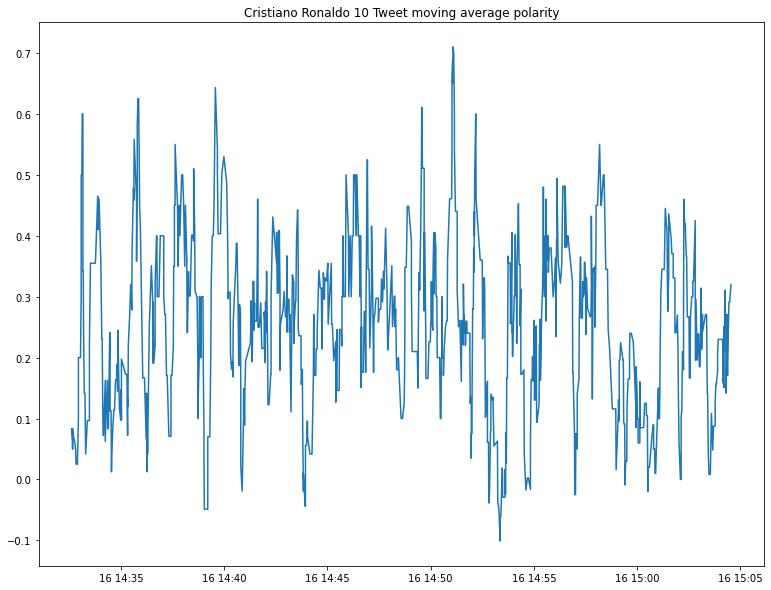

In [208]:
#Plotting the moving average plot
fig,axes=plt.subplots(1,1,figsize=(13,10))
axes.plot(moving_average['Timestamp'],moving_average['MA polarity'])
axes.set_title(hashtag+" 10 Tweet moving average polarity")